# Import Packages

In [1]:
import numpy as np
import pandas as pd
import data_clean_utils
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split

In [2]:
%pip install mlflow dagshub

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import dagshub
dagshub.init(repo_owner='rishavkumar1951', repo_name='swiggy-delivery-time-predictions', mlflow=True)

Accessing as rishavkumar1951

Initialized MLflow to track repo "rishavkumar1951/swiggy-delivery-time-predictions"

Repository rishavkumar1951/swiggy-delivery-time-predictions initialized!

In [4]:
from sklearn import set_config

set_config(transform_output="pandas")

# Load the Data

In [5]:
# load the data

df = pd.read_csv('swiggy.csv')

# Clean Data

In [6]:
data_clean_utils.perform_data_cleaning(df)

In [7]:
# load the cleaned data

df = pd.read_csv('swiggy_cleaned.csv')

df

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,order_day,order_month,order_day_of_week,is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day,distance,distance_type
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,19,3,saturday,1,15.0,11.0,morning,3.025149,short
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,25,3,friday,0,5.0,19.0,evening,20.183530,very_long
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,19,3,saturday,1,15.0,8.0,morning,1.552758,short
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,5,4,tuesday,0,10.0,18.0,evening,7.790401,medium
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,26,3,saturday,1,15.0,13.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,JAPRES04DEL01,30.0,4.8,26.902328,75.794257,26.912328,75.804257,2022-03-24,windy,high,...,JAP,24,3,thursday,0,10.0,11.0,morning,1.489846,short
45498,AGRRES16DEL01,21.0,4.6,NaN,NaN,NaN,NaN,2022-02-16,windy,jam,...,AGR,16,2,wednesday,0,15.0,19.0,evening,NaN,NaN
45499,CHENRES08DEL03,30.0,4.9,13.022394,80.242439,13.052394,80.272439,2022-03-11,cloudy,low,...,CHEN,11,3,friday,0,15.0,23.0,night,4.657195,short
45500,COIMBRES11DEL01,20.0,4.7,11.001753,76.986241,11.041753,77.026241,2022-03-07,cloudy,high,...,COIMB,7,3,monday,0,5.0,13.0,afternoon,6.232393,medium


In [8]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'order_day', 'order_month',
       'order_day_of_week', 'is_weekend', 'pickup_time_minutes',
       'order_time_hour', 'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [9]:
# drop columns not required for model input

columns_to_drop =  ['rider_id',
                    'restaurant_latitude',
                    'restaurant_longitude',
                    'delivery_latitude',
                    'delivery_longitude',
                    'order_date',
                    "order_time_hour",
                    "order_day",
                    "city_name",
                    "order_day_of_week",
                    "order_month"]

df.drop(columns=columns_to_drop, inplace=True)

df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
45498,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,36,0,15.0,evening,NaN,NaN
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [10]:
# check for missing values

df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

In [11]:
# check for duplicates

df.duplicated().sum()

0

<Axes: >

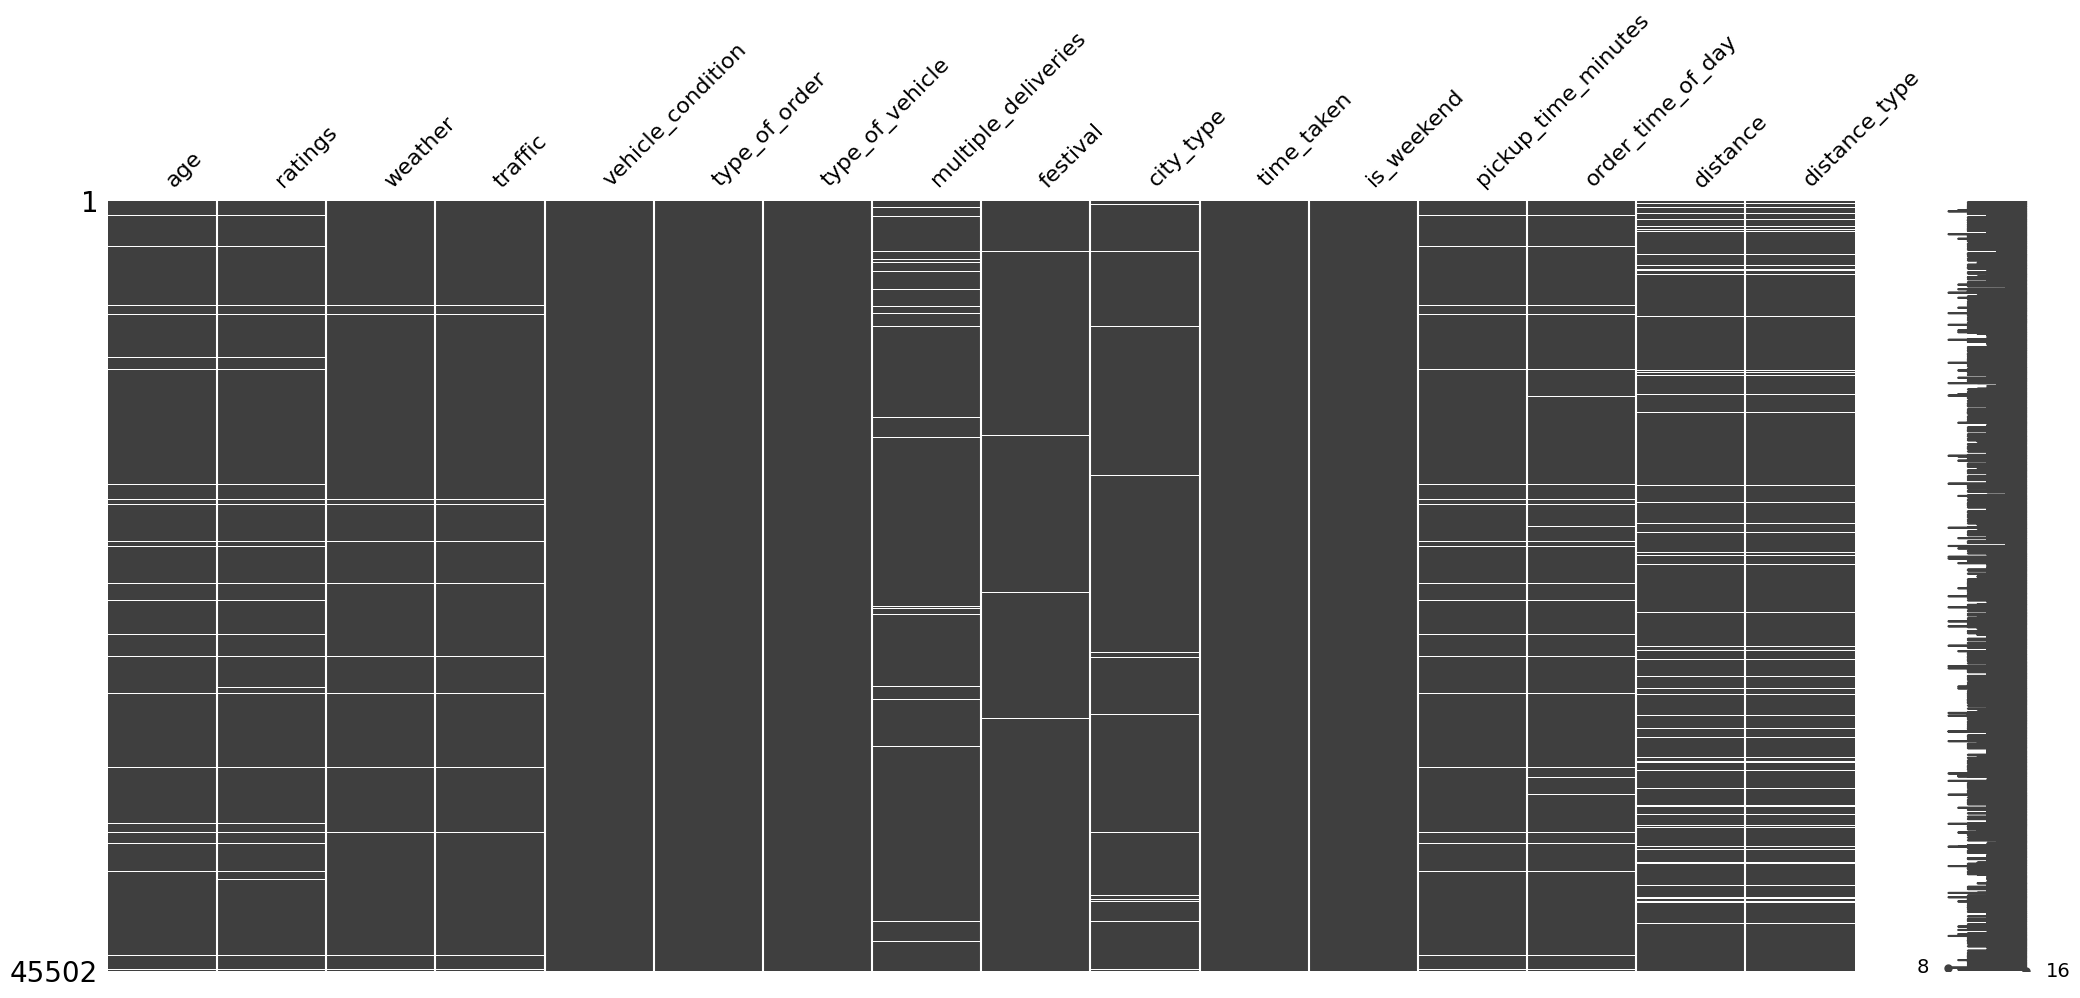

In [12]:
import missingno as msno

msno.matrix(df)

In [13]:
# columns that have missing values

missing_cols = (
                    df
                    .isna()
                    .any(axis=0)
                    .loc[lambda x: x]
                    .index
                )

missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

# Drop Missing Values



In [14]:
import mlflow

In [15]:
# set the tracking server

mlflow.set_tracking_uri("https://dagshub.com/rishavkumar1951/swiggy-delivery-time-predictions.mlflow")

In [16]:
# mlflow experiment

mlflow.set_experiment("Exp 1 - Keep Vs Drop Missing Values")

2025/05/15 14:20:07 INFO mlflow.tracking.fluent: Experiment with name 'Exp 1 - Keep Vs Drop Missing Values' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/045c885f83924b179f5c666724e996a3', creation_time=1747299008811, experiment_id='0', last_update_time=1747299008811, lifecycle_stage='active', name='Exp 1 - Keep Vs Drop Missing Values', tags={}>

In [17]:
temp_df = df.copy().dropna()

In [18]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45496,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,0,10.0,night,16.600272,very_long
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [19]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [20]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (30156, 15)
The shape of test data is (7539, 15)


In [21]:
y_train

8708     49
25198    31
34049    11
25987    24
37121    31
         ..
20239    30
7590     24
13610    15
1045     26
18968    28
Name: time_taken, Length: 30156, dtype: int64

In [22]:
# missing data in training data

X_train.isna().sum()

age                    0
ratings                0
weather                0
traffic                0
vehicle_condition      0
type_of_order          0
type_of_vehicle        0
multiple_deliveries    0
festival               0
city_type              0
is_weekend             0
pickup_time_minutes    0
order_time_of_day      0
distance               0
distance_type          0
dtype: int64

In [23]:
X_train.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'is_weekend', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [24]:
len(X_train.columns)

15

In [25]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [26]:
len(num_cols + nominal_cat_cols + ordinal_cat_cols)

13

In [27]:
for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'high' 'low']
distance_type ['medium' 'short' 'long' 'very_long']


In [28]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [29]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order]), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

preprocessor.set_output(transform="pandas")

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']]),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [30]:
# transform the data

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)

X_train_trans

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,traffic,distance_type,vehicle_condition,multiple_deliveries
8708,0.473684,0.56,1.0,0.404165,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,0,2.0
25198,1.000000,0.76,0.0,0.154044,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,1.0
34049,0.473684,0.80,0.5,0.002461,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1,0.0
25987,1.000000,0.92,1.0,0.460411,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,1.0
37121,0.526316,0.76,0.5,0.243676,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20239,0.578947,0.92,0.5,0.451895,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,0,0.0
7590,0.052632,1.00,1.0,0.612270,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1,1.0
13610,0.526316,0.92,0.0,0.322877,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,0.0
1045,0.947368,0.96,0.5,0.004486,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,1.0


In [31]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [32]:
pt.lambdas_

array([0.32446096])

In [33]:
y_train_pt

,x0
0,2.028672
1,0.554539
2,-2.024267
3,-0.173699
4,0.554539
...,...
30151,0.457580
30152,-0.173699
30153,-1.350937
30154,0.047111


In [34]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train_trans,y_train_pt.values.ravel())

RandomForestRegressor()

y_train_pt.values.ravel() ensures that the target variable (y_train_pt) is converted into a 1D array.

.values extracts the NumPy array from a pandas DataFrame or Series.

.ravel() flattens the array, which is necessary when the target variable is stored as a column vector (e.g., [ [1], [2], [3] ] instead of [1, 2, 3]).

In [35]:
# get the predictions
y_pred_train = rf.predict(X_train_trans)
y_pred_test = rf.predict(X_test_trans)

In [36]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [37]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.15 minutes
The test error is 3.09 minutes


In [38]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.98
The test r2 score is 0.83


In [39]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf,X_train_trans,y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.8080813 , 0.81032091, 0.81114958, 0.80996923, 0.81174737])

In [40]:
# mean score

scores.mean()

0.8102536784376195

<Axes: >

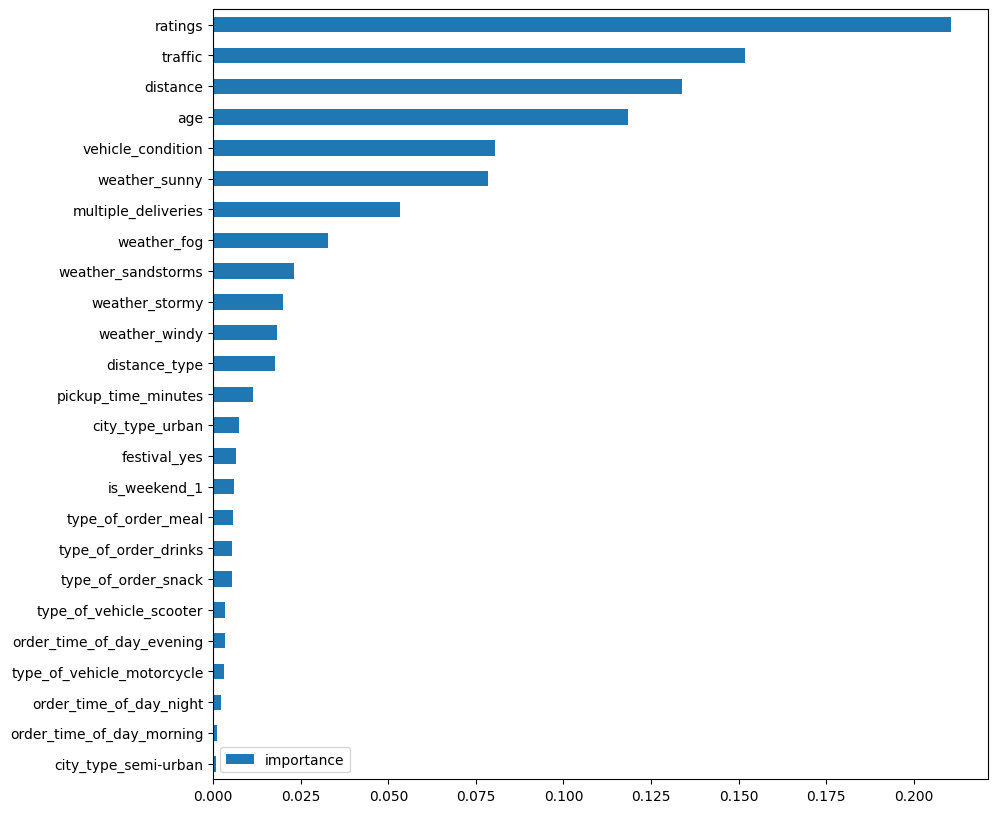

In [41]:
# feature importance plot

(
    pd.DataFrame(rf.feature_importances_,
             index=X_train_trans.columns,
             columns=["importance"])
    .sort_values(by="importance")
    .plot(kind='barh',figsize=(10,10))
)

In [42]:
# log experiment

with mlflow.start_run(run_name="Drop Missing Values"):
    # mlflow log experiment type
    mlflow.log_param("experiment_type","Drop Missing Values")
    # log model params
    mlflow.log_params(rf.get_params())

    # log metrics
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",scores.mean())


🏃 View run Drop Missing Values at: https://dagshub.com/rishavkumar1951/swiggy-delivery-time-predictions.mlflow/#/experiments/0/runs/d7da5d9fc4ab467398ed7022a487362d
🧪 View experiment at: https://dagshub.com/rishavkumar1951/swiggy-delivery-time-predictions.mlflow/#/experiments/0


In [ ]:
from sklearn.feature_selection import RFECV 

RFECV stands for Recursive Feature Elimination with Cross-Validation, and it's a feature selection method available in sklearn.feature_selection. It helps in selecting the most important features from a dataset by iteratively removing the least important ones while evaluating performance using cross-validation.

How RFECV Works

- Starts with All Features – It begins with all features in the dataset.
- Recursive Elimination – It trains a model and removes the least important feature based on the model’s importance scores.
- Cross-Validation Check – It evaluates model performance using cross-validation to determine the optimal number of features.
- Final Selection – It stops when removing features starts to negatively impact performance.

In [44]:
# feature selection using rfecv

rfecv = RFECV(
    estimator=rf,
    step=10,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

In [45]:
# select features

rfecv.fit(X_train_trans,y_train_pt.values.ravel())

RFECV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1, scoring='r2', step=10,
      verbose=2)

In [46]:
# list of selected features

rfecv.get_feature_names_out()

array(['age', 'ratings', 'pickup_time_minutes', 'distance', 'weather_fog',
       'weather_sandstorms', 'weather_stormy', 'weather_sunny',
       'weather_windy', 'type_of_order_drinks', 'type_of_order_meal',
       'type_of_order_snack', 'type_of_vehicle_motorcycle',
       'type_of_vehicle_scooter', 'festival_yes', 'city_type_semi-urban',
       'city_type_urban', 'is_weekend_1', 'order_time_of_day_evening',
       'order_time_of_day_morning', 'order_time_of_day_night', 'traffic',
       'distance_type', 'vehicle_condition', 'multiple_deliveries'],
      dtype=object)

In [47]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(rfecv.transform(X_train_trans),y_train_pt.values.ravel())

RandomForestRegressor()

rfecv refers to RFECV, which applies Recursive Feature Elimination with Cross-Validation.

transform(X_train_trans) selects only the most important features, reducing dimensionality while keeping useful information.

In [48]:
# get the predictions
y_pred_train = rf.predict(rfecv.transform(X_train_trans))
y_pred_test = rf.predict(rfecv.transform(X_test_trans))

In [49]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [50]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.15 minutes
The test error is 3.09 minutes


In [51]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.98
The test r2 score is 0.83


In [52]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf,rfecv.transform(X_train_trans),y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.80807568, 0.81100486, 0.81002672, 0.80849438, 0.81117823])

In [53]:
# mean score

scores.mean()

0.809755972878718

In [54]:
rf.feature_importances_

array([0.11888133, 0.21105364, 0.01158876, 0.13137856, 0.03263331,
       0.02303362, 0.01950075, 0.07879068, 0.01839125, 0.00534064,
       0.0055359 , 0.00534812, 0.00309988, 0.00346363, 0.00637234,
       0.00078963, 0.00723392, 0.00587653, 0.00324466, 0.00121277,
       0.00222242, 0.15232636, 0.02086345, 0.0806289 , 0.05118896])

<Axes: >

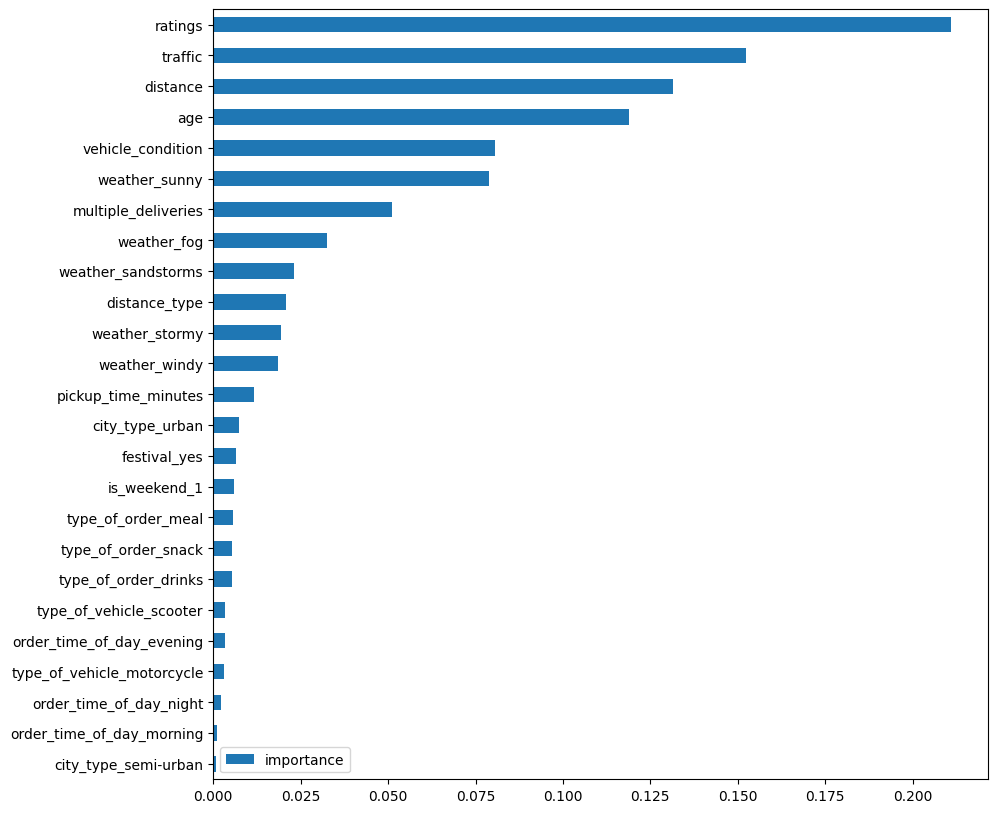

In [55]:
# feature importance plot

(
    pd.DataFrame(rf.feature_importances_,
             index=rfecv.transform(X_train_trans).columns,
             columns=["importance"])
    .sort_values(by="importance")
    .plot(kind='barh',figsize=(10,10))
)

# Impute Missing values

In [56]:
temp_df = df.copy()

In [57]:
# split into X and y

X = temp_df.drop(columns='time_taken')
y = temp_df['time_taken']

X

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45497,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,0,10.0,morning,1.489846,short
45498,21.0,4.6,windy,jam,0,buffet,motorcycle,1.0,no,metropolitian,0,15.0,evening,NaN,NaN
45499,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,0,15.0,night,4.657195,short
45500,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,0,5.0,afternoon,6.232393,medium


In [58]:
# train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [59]:
print("The size of train data is",X_train.shape)
print("The shape of test data is",X_test.shape)

The size of train data is (36401, 15)
The shape of test data is (9101, 15)


In [60]:
# missing values in train data

X_train.isna().sum()

age                    1470
ratings                1510
weather                 421
traffic                 407
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     795
festival                188
city_type               968
is_weekend                0
pickup_time_minutes    1298
order_time_of_day      1646
distance               2931
distance_type          2931
dtype: int64

In [61]:
# transform target column

pt = PowerTransformer()

y_train_pt = pt.fit_transform(y_train.values.reshape(-1,1))
y_test_pt = pt.transform(y_test.values.reshape(-1,1))

In [62]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'pickup_time_minutes', 'order_time_of_day',
       'distance', 'distance_type'],
      dtype='object')

In [63]:
# percentage of rows in data having missing values

(
    X_train
    .isna()
    .any(axis=1)
    .mean()
    .round(2) * 100
)


17.0

# Imputation Pipeline

In [64]:
nominal_cat_cols

['weather',
 'type_of_order',
 'type_of_vehicle',
 'festival',
 'city_type',
 'is_weekend',
 'order_time_of_day']

In [65]:
X_train.isna().sum()

age                    1470
ratings                1510
weather                 421
traffic                 407
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     795
festival                188
city_type               968
is_weekend                0
pickup_time_minutes    1298
order_time_of_day      1646
distance               2931
distance_type          2931
dtype: int64

In [66]:
# features to fill values with mode

features_to_fill_mode = ['multiple_deliveries','festival','city_type']
features_to_fill_missing = [col for col in nominal_cat_cols if col not in features_to_fill_mode]

features_to_fill_missing

['weather',
 'type_of_order',
 'type_of_vehicle',
 'is_weekend',
 'order_time_of_day']

In [67]:
# simple imputer to fill categorical vars with mode

simple_imputer = ColumnTransformer(transformers=[
    ("mode_imputer",SimpleImputer(strategy="most_frequent"),features_to_fill_mode),
    ("missing_imputer",SimpleImputer(strategy="constant",fill_value="missing"),features_to_fill_missing)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)

simple_imputer

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('mode_imputer',
                                 SimpleImputer(strategy='most_frequent'),
                                 ['multiple_deliveries', 'festival',
                                  'city_type']),
                                ('missing_imputer',
                                 SimpleImputer(fill_value='missing',
                                               strategy='constant'),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'is_weekend', 'order_time_of_day'])],
                  verbose_feature_names_out=False)

3. Explanation of Each Parameter
   
📌 Transformers

("mode_imputer", SimpleImputer(strategy="most_frequent"), features_to_fill_mode)

Creates an imputer named "mode_imputer" using SimpleImputer(strategy="most_frequent").

Replaces missing values in features_to_fill_mode with the most frequently occurring value.

("missing_imputer", SimpleImputer(strategy="constant", fill_value="missing"), features_to_fill_missing)

Creates another imputer named "missing_imputer" using SimpleImputer(strategy="constant", fill_value="missing").

Replaces missing values in features_to_fill_missing with the constant "missing", ensuring data consistency.


📌 Other Parameters

remainder="passthrough"

Ensures all columns not explicitly transformed are kept unchanged.

Without this, non-specified columns would be removed.

n_jobs=-1

Enables parallel processing using all available CPU cores for better performance.

force_int_remainder_cols=False

Ensures integer-type columns remain unchanged.

verbose_feature_names_out=False

Controls whether transformed feature names should be verbose.

💡 Summary
This pipeline:

- Fills missing values in selected columns using different strategies (most_frequent & constant).
- Preserves columns not included in transformations (passthrough).
- Optimizes performance by running in parallel (n_jobs=-1).
- Keeps original feature names without verbose modifications.
- Would you like an example of how to apply this to a dataset? 🚀

In [68]:
simple_imputer.fit_transform(X_train)

,multiple_deliveries,festival,city_type,weather,type_of_order,type_of_vehicle,is_weekend,order_time_of_day,age,ratings,traffic,vehicle_condition,pickup_time_minutes,distance,distance_type
11029,1.0,no,metropolitian,windy,snack,electric_scooter,0,evening,26.0,4.7,jam,2,10.0,9.177684,medium
15665,1.0,no,metropolitian,windy,drinks,motorcycle,0,afternoon,21.0,4.9,medium,2,5.0,6.081536,medium
14475,1.0,no,metropolitian,stormy,meal,scooter,1,missing,NaN,NaN,low,2,NaN,1.554563,short
29199,1.0,no,metropolitian,windy,buffet,motorcycle,0,evening,32.0,4.7,medium,0,15.0,20.852271,very_long
22514,0.0,no,urban,sandstorms,meal,scooter,0,night,34.0,4.9,jam,1,5.0,9.056096,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.0,no,metropolitian,sandstorms,meal,scooter,0,evening,29.0,4.7,jam,2,5.0,12.464367,long
44732,0.0,no,urban,cloudy,buffet,motorcycle,0,morning,36.0,4.8,low,0,10.0,1.520432,short
38158,0.0,no,metropolitian,fog,buffet,scooter,0,evening,36.0,4.4,jam,1,10.0,NaN,NaN
860,1.0,no,metropolitian,windy,meal,scooter,1,afternoon,25.0,4.9,medium,2,5.0,7.760938,medium


In [69]:
simple_imputer.fit_transform(X_train).isna().sum()

multiple_deliveries       0
festival                  0
city_type                 0
weather                   0
type_of_order             0
type_of_vehicle           0
is_weekend                0
order_time_of_day         0
age                    1470
ratings                1510
traffic                 407
vehicle_condition         0
pickup_time_minutes    1298
distance               2931
distance_type          2931
dtype: int64

In [70]:
# knn imputer

knn_imputer = KNNImputer(n_neighbors=5)

In [71]:
# do basic preprocessing

num_cols = ["age","ratings","pickup_time_minutes","distance"]

nominal_cat_cols = ['weather','type_of_order',
                    'type_of_vehicle',"festival",
                    "city_type",
                    "is_weekend",
                    "order_time_of_day"]

ordinal_cat_cols = ["traffic","distance_type"]

In [72]:
# generate order for ordinal encoding

traffic_order = ["low","medium","high","jam"]

distance_type_order = ["short","medium","long","very_long"]

In [73]:
# unique categories the ordinal columns

for col in ordinal_cat_cols:
    print(col,X_train[col].unique())

traffic ['jam' 'medium' 'low' 'high' nan]
distance_type ['medium' 'short' 'very_long' 'long' nan]


In [74]:
# build a preprocessor

preprocessor = ColumnTransformer(transformers=[
    ("scale", MinMaxScaler(), num_cols),
    ("nominal_encode", OneHotEncoder(drop="first",handle_unknown="ignore",
                                     sparse_output=False), nominal_cat_cols),
    ("ordinal_encode", OrdinalEncoder(categories=[traffic_order,distance_type_order],
                                      encoded_missing_value=-999,
                                      handle_unknown="use_encoded_value",
                                      unknown_value=-1), ordinal_cat_cols)
],remainder="passthrough",n_jobs=-1,force_int_remainder_cols=False,verbose_feature_names_out=False)


preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [75]:
preprocessor.fit_transform(X_train)

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,weather_nan,...,city_type_nan,is_weekend_1,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,order_time_of_day_nan,traffic,distance_type,vehicle_condition,multiple_deliveries
11029,0.315789,0.88,0.5,0.395429,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,2,1.0
15665,0.052632,0.96,0.0,0.236688,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0
14475,NaN,NaN,NaN,0.004588,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1.0
29199,0.631579,0.88,1.0,0.993990,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0,1.0
22514,0.736842,0.96,0.0,0.389195,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.473684,0.88,0.0,0.563939,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2,0.0
44732,0.842105,0.92,0.5,0.002839,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
38158,0.842105,0.76,0.5,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,-1.0,1,0.0
860,0.263158,0.96,0.0,0.322792,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0


In [76]:
preprocessor.fit_transform(X_train).isna().sum().loc[lambda ser : ser.ge(1)]

age                    1470
ratings                1510
pickup_time_minutes    1298
distance               2931
multiple_deliveries     795
dtype: int64

In [77]:
# build the pipeline

processing_pipeline = Pipeline(steps=[
                                ("simple_imputer",simple_imputer),
                                ("preprocess",preprocessor),
                                ("knn_imputer",knn_imputer)
                            ])

processing_pipeline

Pipeline(steps=[('simple_imputer',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('mode_imputer',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['multiple_deliveries',
                                                   'festival', 'city_type']),
                                                 ('missing_imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant'),
                                                  ['weather', 'type_of_order',
                                                   'type_of_vehi...
                                                   'type_of_vehicle',
                                                   'festival', 'city_type',
                                                   'is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encode',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False)),
                ('knn_imputer', KNNImputer())])

In [78]:
model_pipe = Pipeline(steps=[
                                ("preprocessing",processing_pipeline),
                                ("model",rf)
                            ])

model_pipe

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                    'is_weekend',
                                                                    'order_time_of_day']),
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor())])

In [79]:
# fit the pipeline on data

model_pipe.fit(X_train,y_train_pt.values.ravel())

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant'),
                                                                   ['weath...
                                                                    'is_weekend',
                                                                    'order_time_of_day']),
                                                                  ('ordinal_encode',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor())])

In [80]:
# get the predictions
y_pred_train = model_pipe.predict(X_train)
y_pred_test = model_pipe.predict(X_test)

In [81]:
# get the actual predictions values

y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1,1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1,1))

In [82]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(y_train,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(y_test,y_pred_test_org):.2f} minutes")

The train error is 1.22 minutes
The test error is 3.29 minutes


In [83]:
print(f"The train r2 score is {r2_score(y_train,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(y_test,y_pred_test_org):.2f}")

The train r2 score is 0.97
The test r2 score is 0.80


In [84]:
# calculate the cross val score

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model_pipe,X_train,y_train_pt.values.ravel(),cv=5,scoring="r2",n_jobs=-1)

scores

array([0.77871902, 0.78446333, 0.78259301, 0.77690387, 0.78171227])

In [85]:
# mean score

scores.mean()

0.7808783013632159

In [ ]:
# log experiment

with mlflow.start_run(run_name="Impute Missing Values"):
    # mlflow log experiment type
    mlflow.log_param("experiment_type","Impute Missing Values")
    # log model params
    mlflow.log_params(rf.get_params())

    # log metrics 
    mlflow.log_metric("training_error",mean_absolute_error(y_train,y_pred_train_org))
    mlflow.log_metric("test_error",mean_absolute_error(y_test,y_pred_test_org))
    mlflow.log_metric("training_r2",r2_score(y_train,y_pred_train_org))
    mlflow.log_metric("test_r2",r2_score(y_test,y_pred_test_org))
    mlflow.log_metric("cross_val",scores.mean())

🏃 View run Impute Missing Values at: https://dagshub.com/rishavkumar1951/swiggy-delivery-time-predictions.mlflow/#/experiments/0/runs/ce08438519824f4c882706073069266c
🧪 View experiment at: https://dagshub.com/rishavkumar1951/swiggy-delivery-time-predictions.mlflow/#/experiments/0
